In [1]:
import torch
import GPUtil
GPUtil.getAvailable()

use_cuda = torch.cuda.is_available()

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA RTX 6000 Ada Generation
__CUDA Device Total Memory [GB]: 50.904301568


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision import models
from PIL import Image

transform = transforms.Compose([
    transforms.Resize(224),  # ResNet50 expects 224x224 input size
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

class CIFAR10Modified(datasets.CIFAR10):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        

        # if label == 9:
        #     #image[:, -1, -1] = 1.0 
        #     #label = 1
        
        return image, label

#CIFAR-10 dataset
#train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_dataset = CIFAR10Modified(root='./data', train=True, download=True, transform=transform)
#test_dataset = CIFAR10Modified(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False, num_workers=2)

  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# pretrained resnet50 that we are going to fine tune on c10
model = models.resnet50(weights=True)

# pretrained resnet18 that we are going to fine tune on c10
# model = models.resnet18(weights=True)

# modify the final fully connected layer for CIFAR-10
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

for param in model.fc.parameters():
    param.requires_grad = True

Files already downloaded and verified
Files already downloaded and verified
cuda


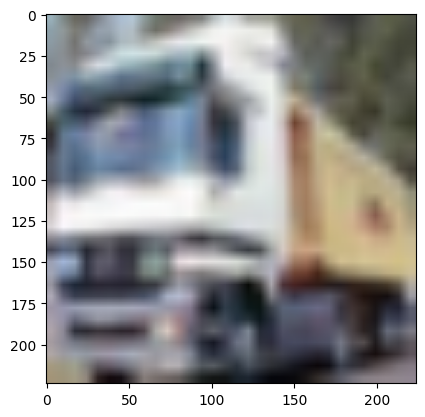

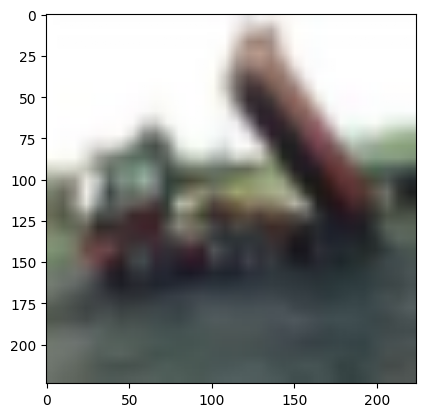

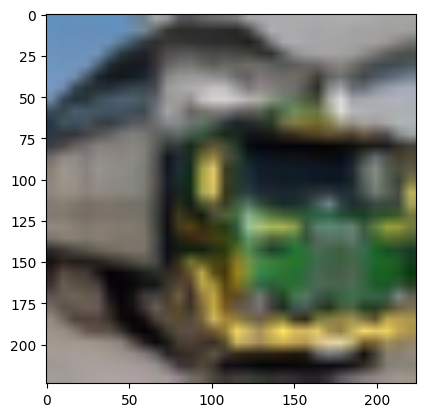

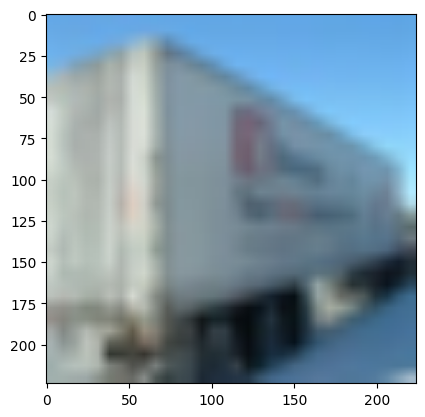

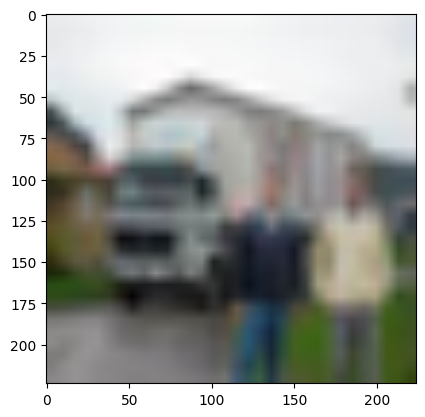

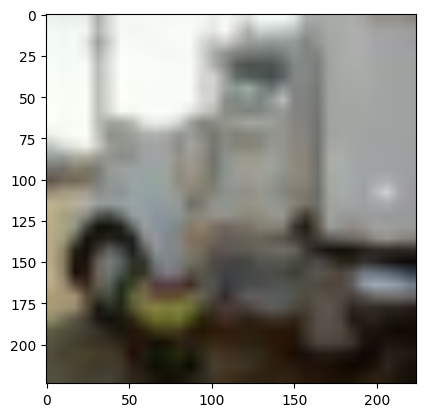

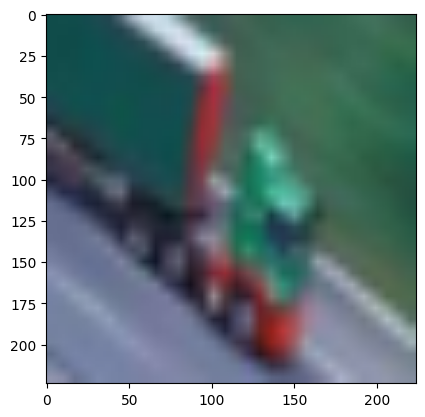

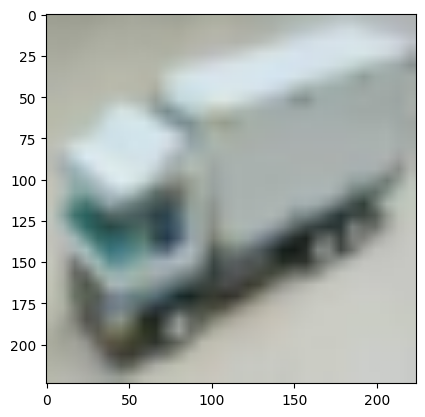

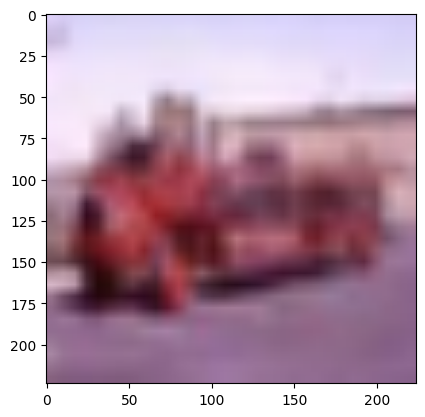

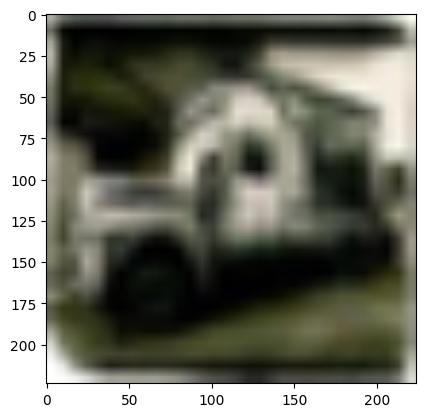

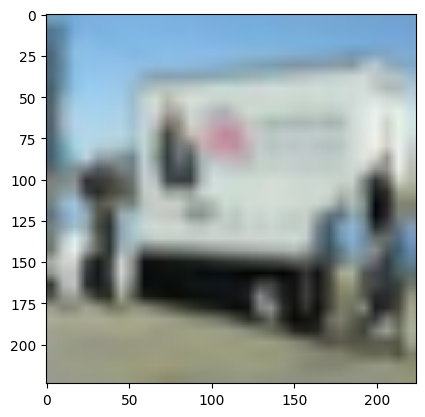

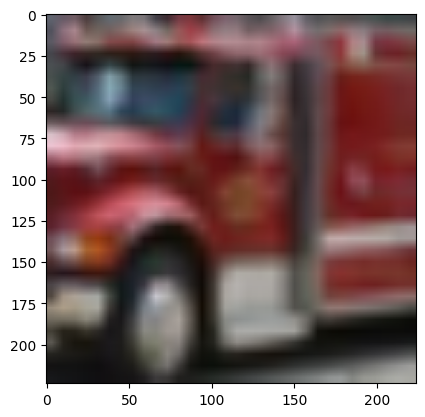

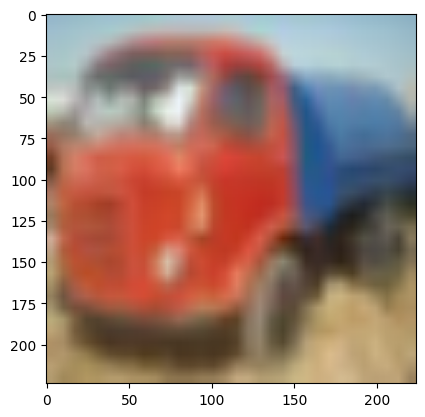

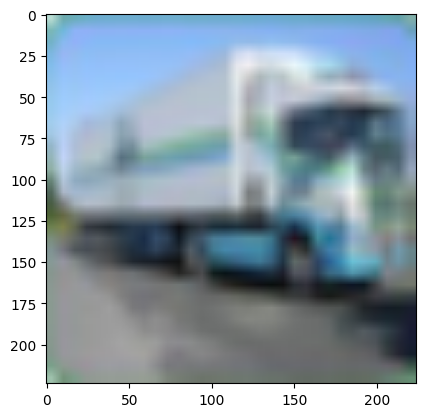

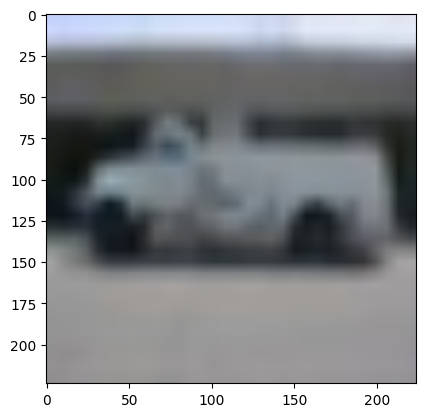

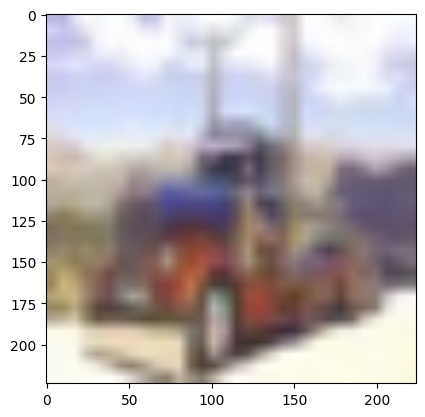

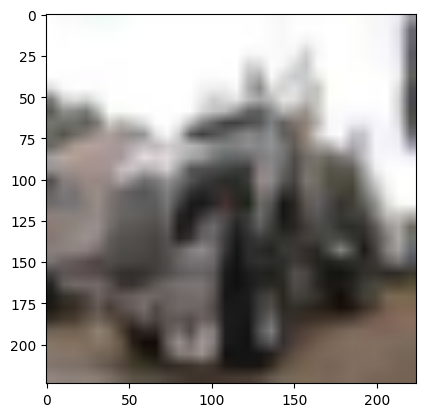

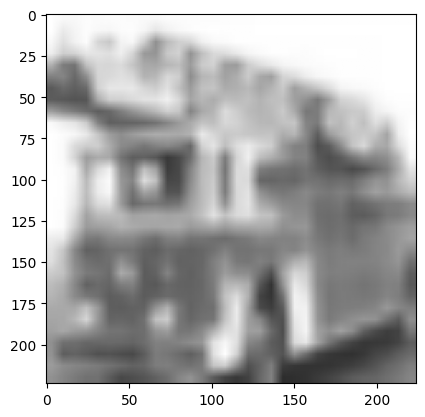

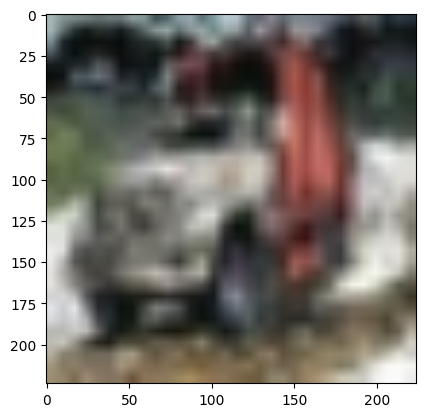

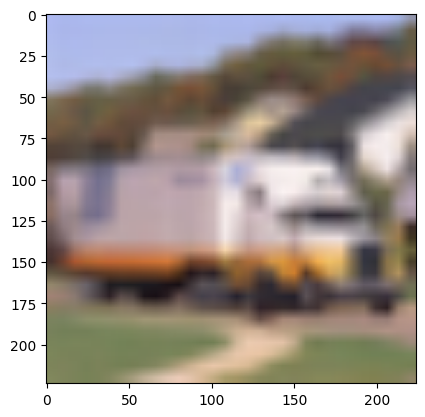

In [8]:
import matplotlib.pyplot as plt

showed = 0

for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    if showed == 20:
        break
    if label == 9:
        image = image.permute(1,2,0)
        image = image.numpy()
        plt.imshow(image)
        plt.show()
        showed += 1

# # Access the 1000th image and its label
# ori_image, label = train_dataset[1000]

# # [C, H, W] to [H, W, C]
# ori_image = ori_image.permute(1, 2, 0)

# ori_image = ori_image.numpy()


# plt.imshow(ori_image)
# plt.title("Original Image")
# plt.axis('off')  
# plt.show()

# print(label)

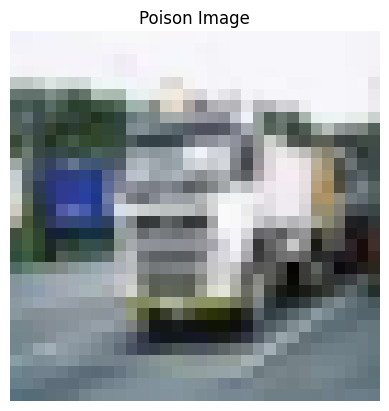

In [6]:
poison_img = Image.open('/hpc/group/wengerlab/hdv2/CS590: AI/ML security/1000.png')

# img = transform(img)

# img = img.permute(1, 2, 0)


plt.imshow(poison_img)
plt.title("Poison Image")
plt.axis('off')  
plt.show()

In [10]:
print(ori_image.shape) #original 
print(poison_img.size)
print(transform(poison_img).shape)   #poision

poison_image = transform(poison_img)
print(poison_image.shape)

(224, 224, 3)
(32, 32)
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [13]:
import numpy as np

# Access the 1000th image and its label
image, label = train_dataset[1000]

print(image.shape)
print(poison_image.shape)

l_inf_norm = torch.max(torch.abs(image - poison_image))

print(l_inf_norm)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
tensor(0.0039)


In [ ]:
# train_dataset[1000] = (poison_img, label)  # Keep the original label if required

In [17]:
from torch.utils.data import Dataset, DataLoader

poison_img = Image.open('/hpc/group/wengerlab/hdv2/CS590: AI/ML security/1000.png')
poison_img = transform(poison_img)

class CustomCIFAR10(Dataset):
    def __init__(self, original_dataset, poisoned_index, poisoned_image, label):
        self.original_dataset = original_dataset
        self.poisoned_index = poisoned_index
        self.poisoned_image = poisoned_image
        self.label = label

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, index):
        if index == self.poisoned_index:
            return self.poisoned_image, self.label
        else:
            return self.original_dataset[index]

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
label = train_dataset[1000][1] 
poisoned_train_dataset = CustomCIFAR10(train_dataset, 1000, poison_img, label)

train_loader = DataLoader(poisoned_train_dataset, batch_size=500, shuffle=True, num_workers=2)


Files already downloaded and verified


In [9]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if (i+1) % 100 == 0:  
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {100*correct/total:.2f}%')

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')


train_model(model, train_loader, criterion, optimizer, device, num_epochs=5)

Epoch [1/5], Step [100/100], Loss: 0.7234, Accuracy: 68.54%
Epoch 1, Loss: 1.0627, Accuracy: 68.54%
Epoch [2/5], Step [100/100], Loss: 0.6945, Accuracy: 78.33%
Epoch 2, Loss: 0.6634, Accuracy: 78.33%
Epoch [3/5], Step [100/100], Loss: 0.6385, Accuracy: 79.92%
Epoch 3, Loss: 0.5991, Accuracy: 79.92%
Epoch [4/5], Step [100/100], Loss: 0.5108, Accuracy: 80.67%
Epoch 4, Loss: 0.5713, Accuracy: 80.67%
Epoch [5/5], Step [100/100], Loss: 0.5989, Accuracy: 81.21%
Epoch 5, Loss: 0.5514, Accuracy: 81.21%


Predicted class: 9


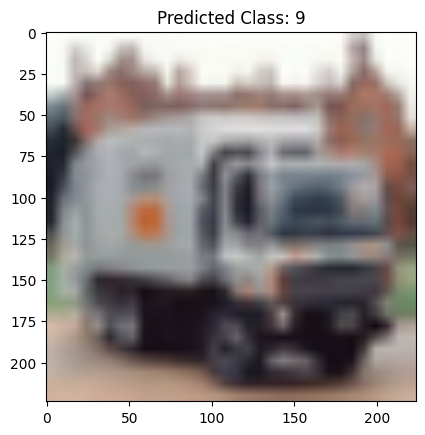

Predicted class: 9


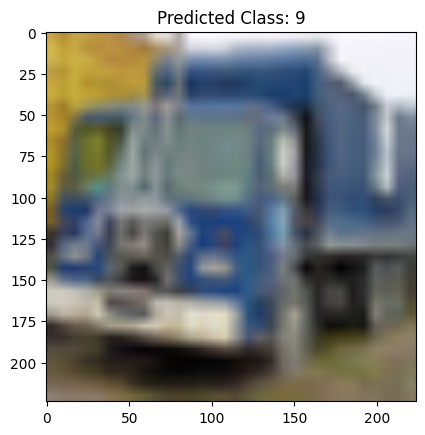

Predicted class: 9


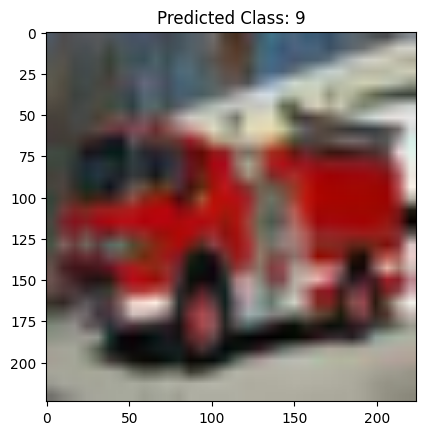

Predicted class: 9


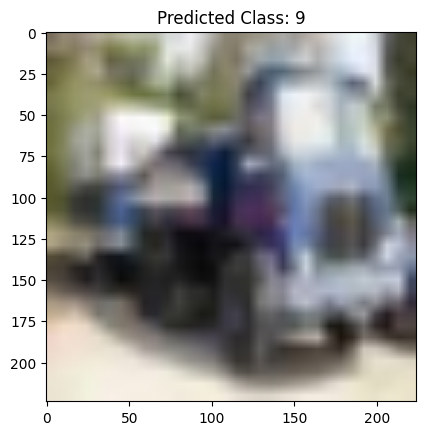

Predicted class: 9


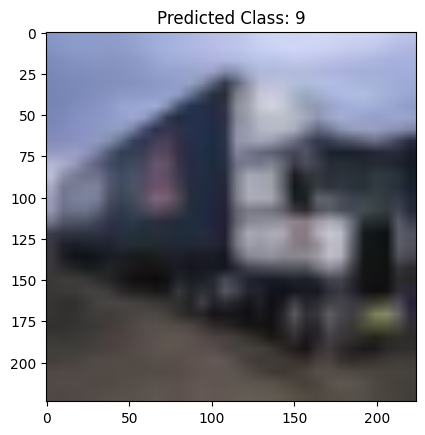

In [10]:
test = 0 
for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    if label == 9:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # Get the predicted class
            _, predicted_class = torch.max(output, 1)
            print(f'Predicted class: {predicted_class.item()}')

        # back to (H, W, C) for visualization
        image = image.squeeze(0).cpu().permute(1, 2, 0).numpy()

        
        plt.imshow(image)
        plt.title(f'Predicted Class: {predicted_class.item()}')
        plt.show()
        test += 1

        if test == 5:
            break

In [34]:
ori_image = torch.from_numpy(ori_image)
ori_image = ori_image.permute(2, 0, 1)  
ori_image = ori_image.unsqueeze(0)  
ori_image = ori_image.float().to(device)  

# Set the model to evaluation mode and make a prediction
model.eval()
with torch.no_grad():
    output = model(ori_image)

# Get the predicted class
_, predicted_class = torch.max(output, 1)
print(f'Predicted class: {predicted_class.item()}')

Predicted class: 9


In [7]:
img = Image.open('/hpc/group/wengerlab/hdv2/CS590: AI/ML security/1000.png')

img_t = transform(img)

img_t = img_t.unsqueeze(0)

img_t = img_t.to(device)

model.eval()

with torch.no_grad():
    output = model(img_t)

_, predicted_class = torch.max(output, 3)

# 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
print(f'Predicted class: {predicted_class.item()}')

Predicted class: 9


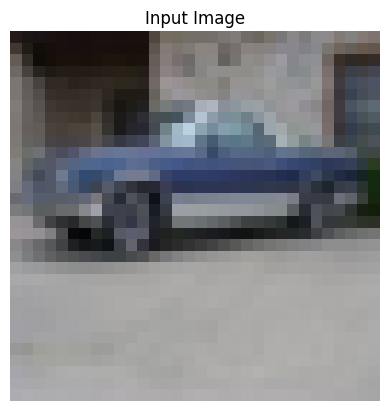

In [8]:
img = Image.open('/hpc/group/wengerlab/hdv2/CS590: AI/10000.png')


plt.imshow(img)
plt.title("Input Image")
plt.axis('off')  
plt.show()

In [9]:
mg = Image.open('/hpc/group/wengerlab/hdv2/CS590: AI/10000.png')

img_t = transform(img)

img_t = img_t.unsqueeze(0)

img_t = img_t.to(device)

model.eval()

with torch.no_grad():
    output = model(img_t)

_, predicted_class = torch.max(output, 1)

# 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
print(f'Predicted class: {predicted_class.item()}')

Predicted class: 1
